In [1]:
import torch
from all_code import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 150000,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 384,        # Embedding dimension
    "n_heads": 6,         # Number of attention heads
    "n_layers": 6,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval();

In [3]:
from all_code import generate_text_simple
from bpe import HindiTokenizer

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    print("Start context:", start_context)
    print("Encoded token ids:", encoded)
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device) #1
    print("Encoded shape:", encoded_tensor.shape)
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "ऑनलाइन क्लास में हमेशा अपने पोस्चर"
tokenizer = HindiTokenizer()
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(start_context, tokenizer),
max_new_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])
Output text:
 ऑनलाइन क्लास में हमेशा अपने पोस्चर बांकाजमीन ढिढां दिशानिर्दे भाभीभूधाफढभे हादसागांव 1110 पॉली अधूरे नुमाया वज़न


In [4]:
file_path = '/home/angkul/my_data/coding/agi/hindi_GPT/hindi.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [5]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 36506
Tokens: 7714


In [6]:
from all_code import create_dataloader

total_characters = len(text_data)
train_ratio = 0.90
split_idx = int(train_ratio*total_characters)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [7]:
torch.manual_seed(32)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [8]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [9]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss/num_batches

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(12.0842, device='cuda:0')
Validation loss: tensor(12.0764, device='cuda:0')


In [11]:
!nvidia-smi

Mon Apr 21 04:38:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0             25W /   30W |    1669MiB /   4096MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [13]:
from tqdm import tqdm
# import gc

In [14]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.reset_max_memory_allocated()
# torch.cuda.reset_peak_memory_stats()

In [15]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [16]:
print(f"start_context: {start_context}")

start_context: ऑनलाइन क्लास में हमेशा अपने पोस्चर


In [17]:
token_ids_list = tokenizer.encode(start_context)
print("Token IDs:", token_ids_list)
print("Number of tokens:", len(token_ids_list))

Token IDs: [1838, 4173, 110, 1898, 296, 29965]
Number of tokens: 6


In [18]:
print(tokenizer.encode("ऑनलाइन"))
print(tokenizer.encode("पोस्टर"))

[1838]
[4542]


In [19]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="ऑनलाइन क्लास में हमेशा अपने पोस्चर", tokenizer=tokenizer
)

  0%|          | 0/10 [00:00<?, ?it/s]

Ep 1 (Step 000000): Train loss 11.811, Val loss 11.735
Ep 1 (Step 000005): Train loss 10.373, Val loss 10.379
Ep 1 (Step 000010): Train loss 9.423, Val loss 9.517
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 10%|█         | 1/10 [00:05<00:46,  5.16s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के के
Ep 2 (Step 000015): Train loss 8.384, Val loss 8.639
Ep 2 (Step 000020): Train loss 7.600, Val loss 7.854
Ep 2 (Step 000025): Train loss 6.793, Val loss 7.344
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 20%|██        | 2/10 [00:10<00:41,  5.16s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर है । है । है । है । है । है । के के है । है । है । के के है । के के है । है । के है । के है । के है । है । के है । के है । है । के
Ep 3 (Step 000030): Train loss 6.400, Val loss 7.114
Ep 3 (Step 000035): Train loss 6.233, Val loss 7.055
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 30%|███       | 3/10 [00:15<00:34,  4.94s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर है । है । है । है । है । है । है । है । और है । है । के है । है । है । है । है । है । है । है । और है । है । और है । है । है ।
Ep 4 (Step 000040): Train loss 6.010, Val loss 7.058
Ep 4 (Step 000045): Train loss 5.960, Val loss 7.092
Ep 4 (Step 000050): Train loss 5.860, Val loss 6.977
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 40%|████      | 4/10 [00:19<00:28,  4.79s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए है । यह है । नर के लिए है । यह और है । यह है । को की के लिए के लिए है । यह है । नर के लिए है । नर । यह और को का की है । को है । को है ।
Ep 5 (Step 000055): Train loss 5.417, Val loss 6.896
Ep 5 (Step 000060): Train loss 5.418, Val loss 6.888
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 50%|█████     | 5/10 [00:23<00:22,  4.59s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए के लिए में यह में मोर के लिए है । कर्मचारियों के लिए में मोर के लिए के लिए में हैं । कर्मचारियों के लिए में एक हैं । यह भी से एक हैं । यह भी से एक हैं । कर्मचारियों के लिए में हैं । यह
Ep 6 (Step 000065): Train loss 5.162, Val loss 6.875
Ep 6 (Step 000070): Train loss 5.050, Val loss 6.866
Ep 6 (Step 000075): Train loss 4.963, Val loss 6.858
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 60%|██████    | 6/10 [00:28<00:19,  4.78s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए के लिए में एक एक है । मोर के लिए में एक एक है । मोर के लिए में एक के लिए एक है । मोर के लिए में यह भी के लिए के लिए में एक और और की तरह के लिए में एक है । यह
Ep 7 (Step 000080): Train loss 4.810, Val loss 6.830
Ep 7 (Step 000085): Train loss 4.696, Val loss 6.834
Ep 7 (Step 000090): Train loss 4.382, Val loss 6.835
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 70%|███████   | 7/10 [00:34<00:14,  4.94s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए नेतृत्व के लिए है । इस प्रकार के लिए है । यह भी होते हैं । और को में भी के लिए नेतृत्व के लिए में एक और कार्य के लिए और और कर्मचारी की तरह एक और और अपने कार्य के लिए में एक है । यह
Ep 8 (Step 000095): Train loss 4.277, Val loss 6.831
Ep 8 (Step 000100): Train loss 4.200, Val loss 6.842
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 80%|████████  | 8/10 [00:39<00:09,  4.94s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए नेतृत्व की तरह की तरह एक और कर्मचारियों को के लिए एक और कर्मचारियों के लिए और के लिए भी के लिए नेतृत्व के लिए एक एक बड़ा में यह आवश्यक है और कर्मचारी की तरह एक और और अपने कार्य के लिए होता है । यह भी
Ep 9 (Step 000105): Train loss 3.823, Val loss 6.820
Ep 9 (Step 000110): Train loss 3.725, Val loss 6.869
Ep 9 (Step 000115): Train loss 3.464, Val loss 6.873
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


 90%|█████████ | 9/10 [00:44<00:05,  5.06s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए नेतृत्व के लिए है । इस प्रकार के लिए है कि वह है कि वह है । कर्मचारियों से में मोर के लिए कर्मचारियों को एक एक को इस प्रकार से अपने के साथ में यह आवश्यक है । मोर को नेता को चाहिए कि वह अपने कार्य
Ep 10 (Step 000120): Train loss 3.407, Val loss 6.877
Ep 10 (Step 000125): Train loss 3.102, Val loss 6.900
Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])


100%|██████████| 10/10 [00:49<00:00,  4.94s/it]

ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए नेतृत्व के लिए यह है । कर्मचारियों को इस प्रकार के लिए नेतृत्व की तरह से में ही में है । इससे कर्मचारी पर ही में एक है । यह है है और कर्मचारी की तरह एक है । कर्मचारियों को नेता को चाहिए कि वह अपने कार्य


In [20]:
def to_cpu_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x

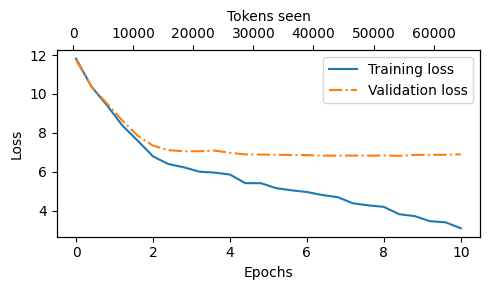

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(
    epochs_tensor.cpu(),
    tokens_seen,
    [loss.item() for loss in train_losses],
    [loss.item() for loss in val_losses]
)

In [ ]:
model.to("cuda")
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("ऑनलाइन क्लास में हमेशा अपने पोस्चर", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])
Output text:
 ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए नेतृत्व के लिए यह है । कर्मचारियों को इस प्रकार के लिए नेतृत्व की तरह से में ही में है । इससे कर्मचारी


In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)  

            idx_next = torch.multinomial(probs, num_samples=1)

        
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [28]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("ऑनलाइन क्लास में हमेशा अपने पोस्चर", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Start context: ऑनलाइन क्लास में हमेशा अपने पोस्चर
Encoded token ids: [1838, 4173, 110, 1898, 296, 29965]
Encoded shape: torch.Size([1, 6])
Output text:
 ऑनलाइन क्लास में हमेशा अपने पोस्चर के लिए कर्मचारी और जो समय के लिए कर्मचारियों को और बाद से हैं ।
